In [24]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Função para visualização da função valor e política a cada iteração

In [18]:
def PlotHeatmaps(v, policy, maxCars, iteration):
    # como foram utilizados vetores 1D, é necessário fazer o reshape
    reshapedV = np.reshape(v, (maxCars + 1, maxCars + 1), order='C')
    reshapedPolicy = np.reshape(policy, (maxCars + 1, maxCars + 1), order='C')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    sns.heatmap(reshapedV, linewidths=0.5, ax=ax1)
    ax1.set_title(f'v{iteration}')

    sns.heatmap(reshapedPolicy, linewidths=0.5, annot=True, ax=ax2)
    ax2.set_title(f'π{iteration}')

    # por causa do jeito que foi definido o array começando com (0,20) foi feita uma inversão dos valores do eixo
    y_labels = [maxCars - i for i in range(maxCars + 1)]
    ax1.set_yticklabels(y_labels, rotation=0)
    ax2.set_yticklabels(y_labels, rotation=0)

    plt.show()

### Definição do Ambiente

In [19]:
class JacksCarRental:
    def __init__(self, rentCredit, moveCost, expReq1, expReq2, expRet1, expRet2,
                 maxCars, maxMoves, gamma):
        self.rentCredit = rentCredit # ganho por aluguel
        self.moveCost = moveCost # custo para mover
        self.expReq1 = expReq1 # pedidos esperados em 1
        self.expReq2 = expReq2 # pedidos esperados em 2
        self.expRet1 = expRet1 # retornos esperados em 1
        self.expRet2 = expRet2 # retornos esperados em 2
        self.maxCars = maxCars # máximo de carros por localidade
        self.maxMoves = maxMoves # movimentos diários
        self.gamma = gamma # fator de desconto

    # formato (cars_loc2 , cars_loc1)
    # loc 2 no eixo X e loc 1 no eixo Y
    # array state começa no canto superior esquerdo
    def CarsPerLoc(self, state):
      gridSide = self.maxCars + 1
      return state % gridSide, (gridSide - 1 - state // gridSide)

    # retorna o índice correspondente ao estado
    def GetState(self, carsLoc1, carsLoc2):
      return (self.maxCars - carsLoc1) * (self.maxCars + 1) + carsLoc2

    # V(s) ← ∑ p(s′,r∣s,π(s))[r+γV′(s)]
    def ExpReturn(self, state, action, v):
      n = 11 # maior número com probabilidade de Poisson não desprezível
      rDeficit = self.moveCost * abs(action) # moveCost < 0
      carsLoc2Prev, carsLoc1Prev = self.CarsPerLoc(state)
      # action > 0 se mover de 1 para 2
      carsLoc1 = min(max(carsLoc1Prev - action, 0), self.maxCars)
      carsLoc2 = min(max(carsLoc2Prev + action, 0), self.maxCars)
      expectedReturn = rDeficit
      for requestsLoc1 in range(0,n):
        requestsProb1 = poisson.pmf(requestsLoc1, self.expReq1)
        rentsLoc1 = min(carsLoc1, requestsLoc1)
        for requestsLoc2 in range(0,n):
          requestsProb2 = poisson.pmf(requestsLoc2, self.expReq2)
          rentsLoc2 = min(carsLoc2, requestsLoc2)
          rProfit = (rentsLoc1 + rentsLoc2) * self.rentCredit
          for returnsLoc1 in range(0,n):
            returnsProb1 = poisson.pmf(returnsLoc1, self.expRet1)
            for returnsLoc2 in range(0,n):
              returnsProb2 = poisson.pmf(returnsLoc2, self.expRet2)
              prob = requestsProb1 * requestsProb2 * returnsProb1 * returnsProb2
              nextState = int(self.GetState(min(carsLoc1 - rentsLoc1 + returnsLoc1, self.maxCars), min(carsLoc2 - rentsLoc2 + returnsLoc2, self.maxCars)))
              expectedReturn += prob * (rProfit + self.gamma * v[nextState])
      return expectedReturn

### Algoritmo Policy Iteration

In [20]:
def PolicyEvaluation(env, policy, v, theta):
  numStates = (env.maxCars + 1) ** 2
  delta = theta
  while delta >= theta:
    delta = 0
    for s in range(numStates):
      oldValue = v[s]
      v[s] = env.ExpReturn(s, policy[s], v)
      delta = max(delta, abs(v[s] - oldValue))
    print(delta)
  return v

def ValidActions(env, state):
  carsLoc2, carsLoc1 = env.CarsPerLoc(state)
  minAction = -min(carsLoc2, env.maxMoves)
  maxAction = min(carsLoc1, env.maxMoves)
  return [i + minAction for i in range(maxAction - minAction + 1)]

def PolicyImprovement(env, policy, v):
  for s in range(len(policy)):
    maxVal = float('-inf')
    for action in ValidActions(env, s):
      actionVal = env.ExpReturn(s, action, v)
      if actionVal > maxVal:
        maxVal = actionVal
        bestAction = action
    policy[s] = bestAction
  return policy

def PolicyIteration(env, policy, v, theta):
  policyStable = False
  k = 1
  while not policyStable:
    oldPolicy = np.copy(policy)
    policyStable = True
    v = PolicyEvaluation(env, policy, v, theta)
    policy = PolicyImprovement(env, policy, v)
    if (policy != oldPolicy).any(): policyStable = False

    PlotHeatmaps(v, policy, env.maxCars, k)
    k += 1

  return v, policy

In [21]:
rentCredit = 10
moveCost = -2
expReq1 = 3
expReq2 = 4
expRet1 = 3
expRet2 = 2
maxCars = 20
maxMove = 5
gamma = 0.9

In [22]:
env = JacksCarRental(rentCredit, moveCost, expReq1, expReq2, expRet1, expRet2, maxCars, maxMove, gamma)
numStates = (maxCars + 1)**2
v = np.zeros(numStates)
policy = np.zeros(numStates)

168.52849647129045
111.47601653716765
82.18135792888174
62.841491724995706
47.925103765245865
36.96015946965895
31.0851898391075
26.02474464579899
21.715512548169272
18.070044337585557
15.00002730638738
12.424129810179238
10.269954440913864
8.473951322163941
6.980767880081146
5.742502399666989
4.717966967746861
3.8719716202499512
3.1746321575970455
2.6007097391356524
2.1289928970226697
1.7417309385084536
1.4241241176814015
1.1638722460098734
0.950780415205088
0.7764184389407092
0.6338293951119454
0.5172820807056837
0.42206208383197463
0.3442963706383466
0.28080665457923715
0.2289872758040019
0.18670380892422145
0.15220910223689543
0.12407390713559607
0.1011296718546646
0.08242144386269956
0.0671691491120896
0.05473579696700881
0.04460139927215323
0.03634159614705368
0.029610152691134317
0.024124635518660398
0.01965469820515864
0.016012505502203567
0.013044909319660292
0.010627058472550743
0.008657181295347982


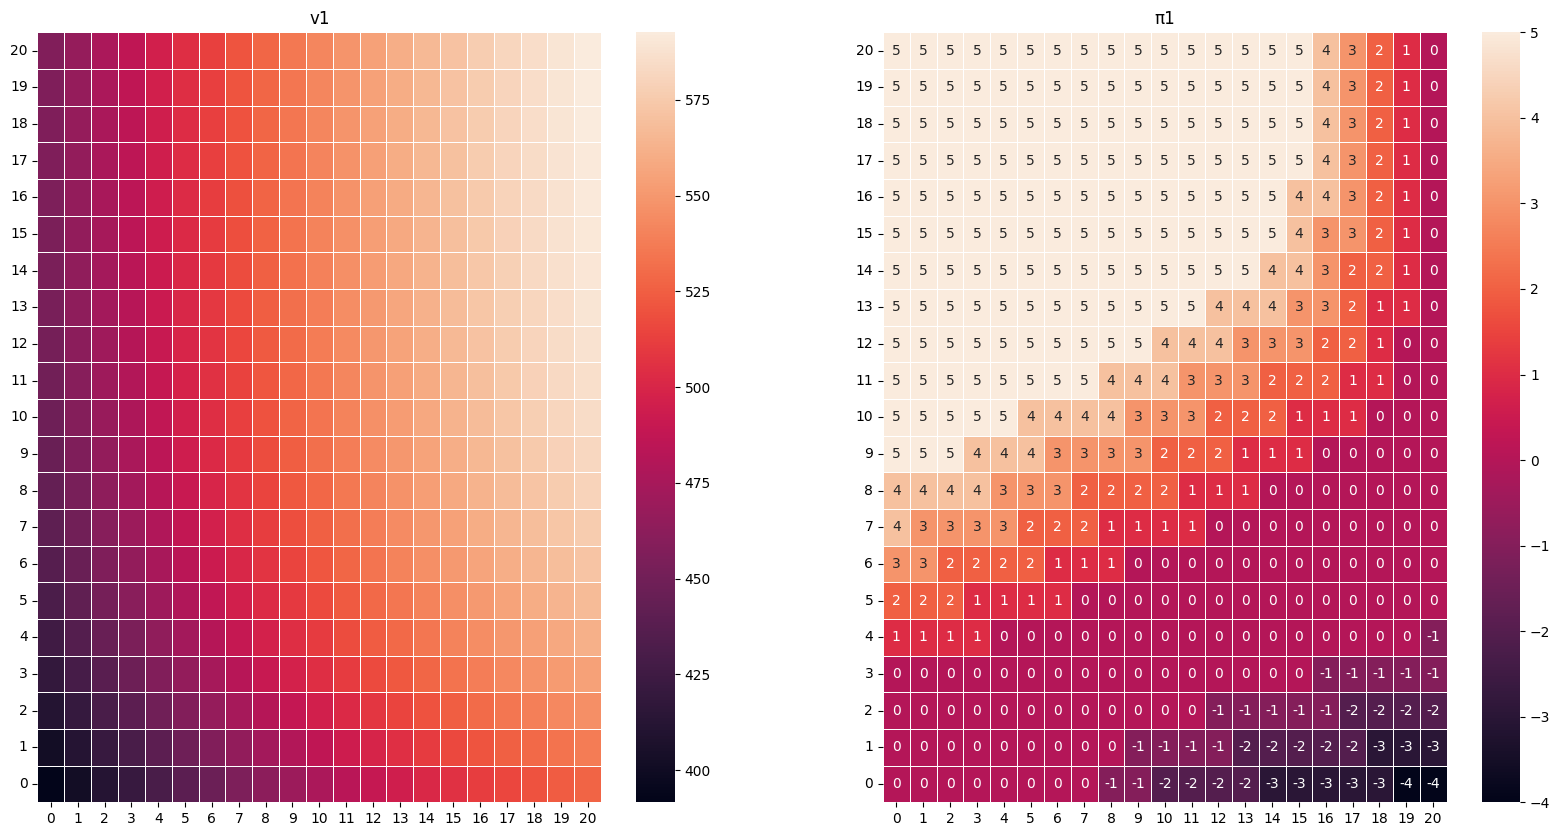

35.40174691130534
21.726666224754297
8.009406717673187
2.3755930737268045
1.2989177757511925
1.0173514914218913
0.8412524930332665
0.6942673500639103
0.5693456009158808
0.46473825195619156
0.37820975948818614
0.3071971985889377
0.25112706522043027
0.206397478077065
0.16884530840650314
0.13766647123418352
0.11198293583890973
0.09094314140679671
0.07377376413933234
0.05980000021156684
0.048447772051076754
0.0392367215364402
0.03176930164056557
0.02571890730087034
0.020818534851173354
0.01685062797946557
0.013638315320008587
0.011038017702503566
0.008933299155728491


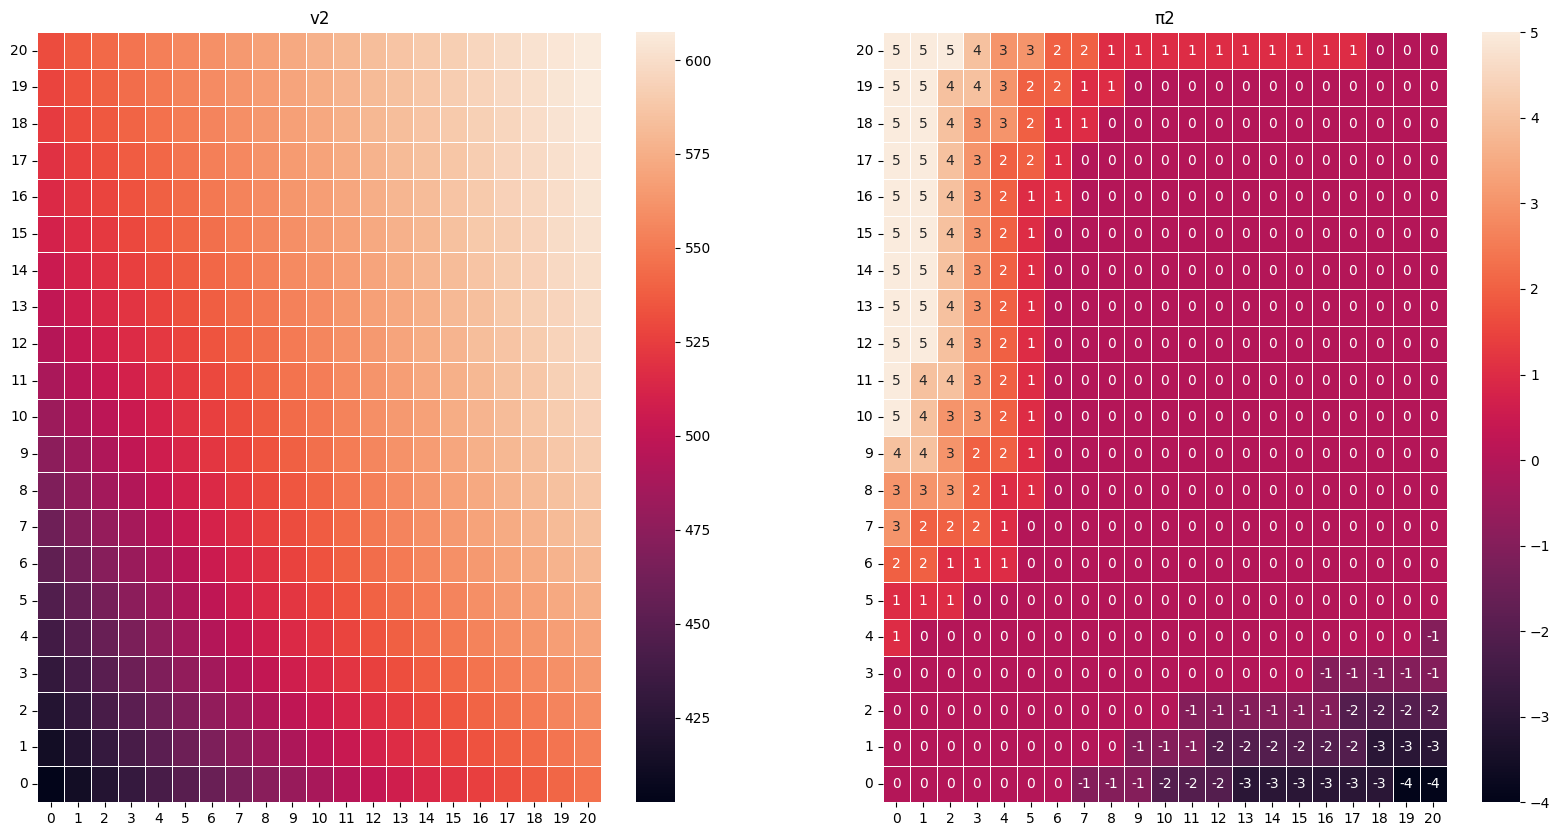

3.977401270649125
2.433598445375196
1.8737554582781968
1.4691290222593807
1.102284517469684
0.8126471721608368
0.5917554924069464
0.4267359141564384
0.3065278804419904
0.22099546767287848
0.161092334465593
0.1199216314196292
0.09092801966198749
0.07008805217151348
0.05476951242201267
0.043750350002824234
0.035236001129646866
0.028434037256943157
0.02297440227437164
0.018578494225721442
0.01503179868711868
0.012166429731223616
0.009849486658026763


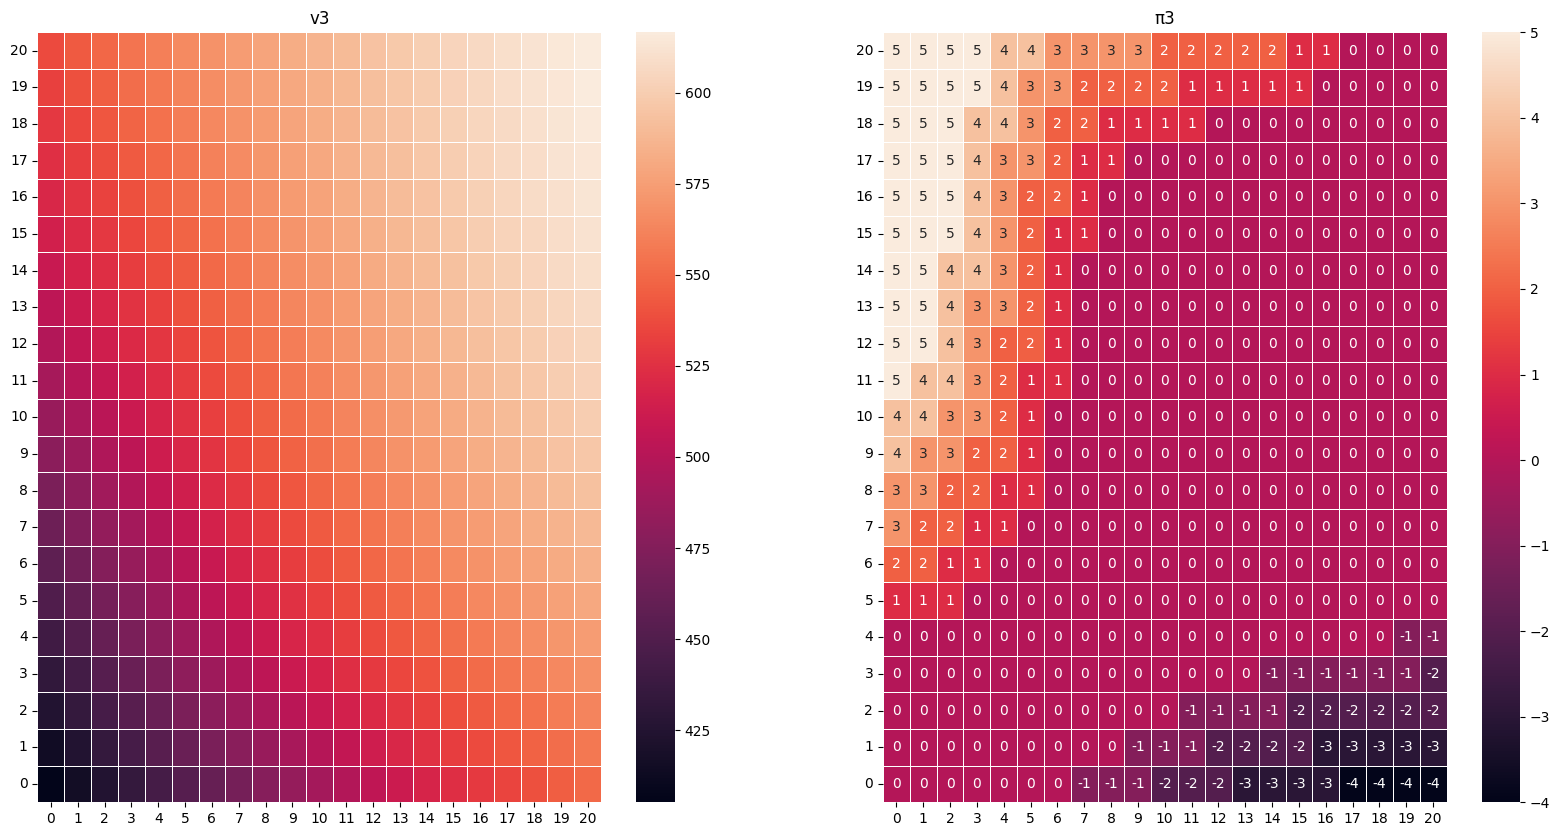

0.48620466990325895
0.13655329396044635
0.07914037601676682
0.05095850082227571
0.03535060411593349
0.024928955190148372
0.017646180177052884
0.012370312296752672
0.008728605436886028


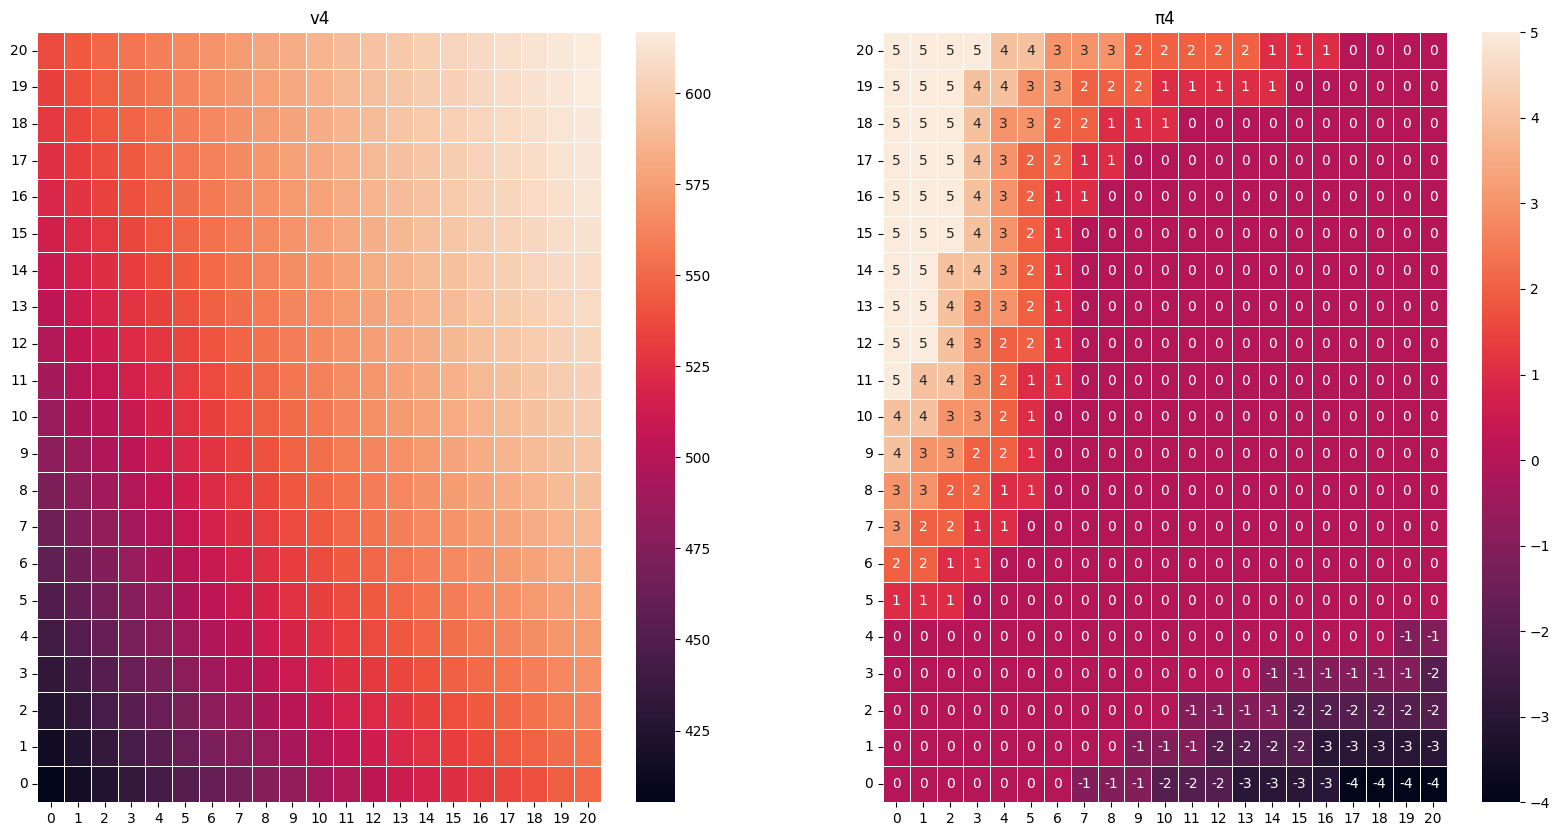

0.05885919293473307
0.011776514851248976
0.006454393658373192


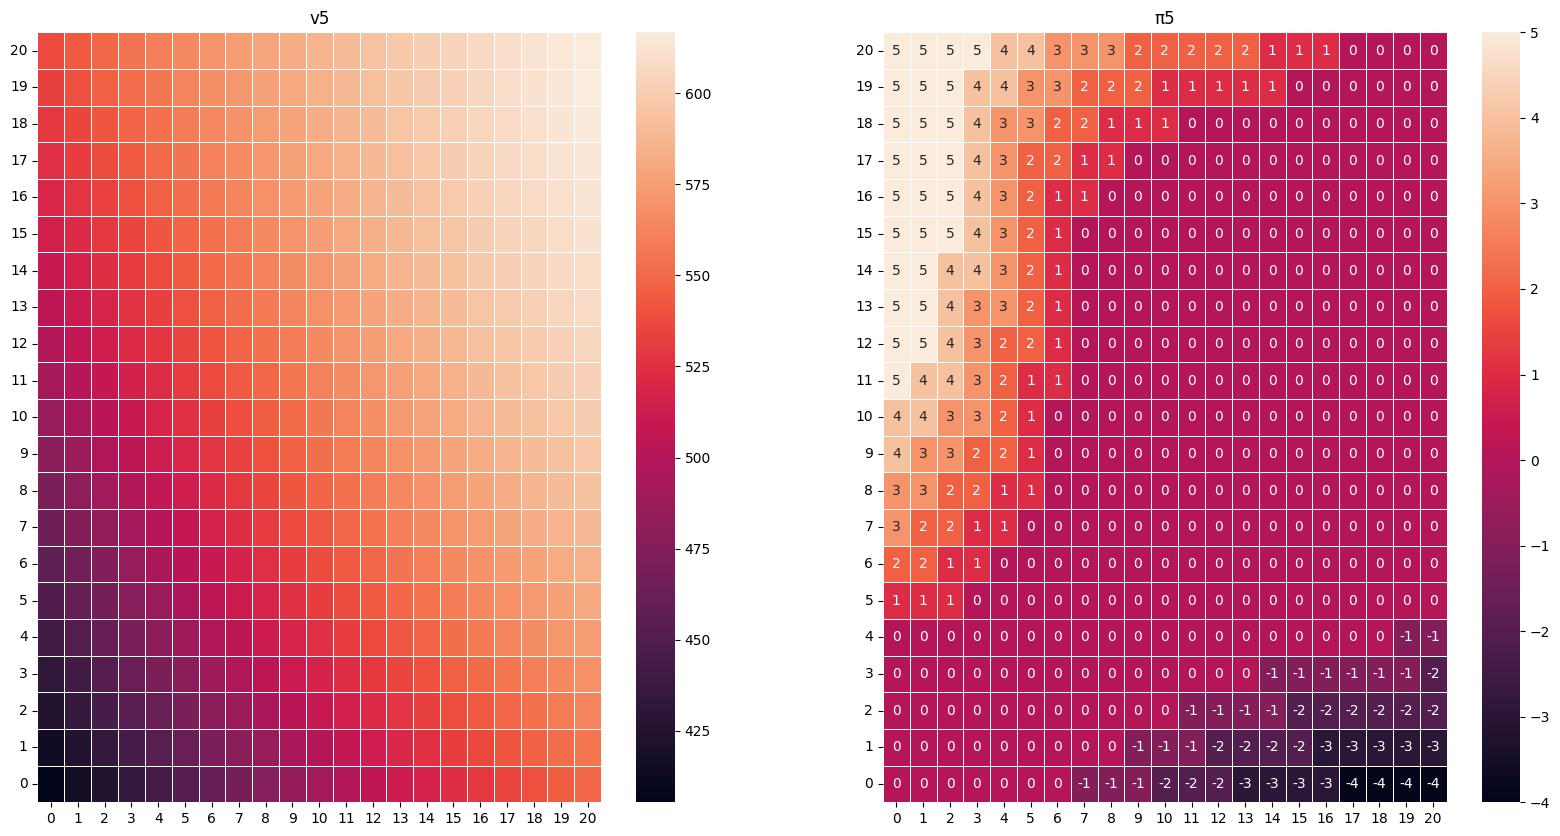

In [23]:
theta = 0.01
v, policy = PolicyIteration(env, policy, v, theta)

In [38]:
def PlotValueFunction3D(v, maxCars):
    x = np.arange(maxCars + 1)
    y = np.arange(maxCars + 1)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')

    # como foram utilizados vetores 1D, é necessário fazer o reshape
    reshapedV = np.reshape(v, (maxCars + 1, maxCars + 1), order='C')
    mirroredV = np.flipud(reshapedV)
    ax.plot_surface(X, Y, mirroredV, cmap='autumn')

    ax.set_xlabel('Total de carros em 2')
    ax.set_ylabel('Total de carros em 1')
    ax.set_title('Função valor para política ideal')

    ax.set_xticks(np.arange(0, maxCars + 1, 5))
    ax.set_yticks(np.arange(0, maxCars + 1, 5))

    plt.show()

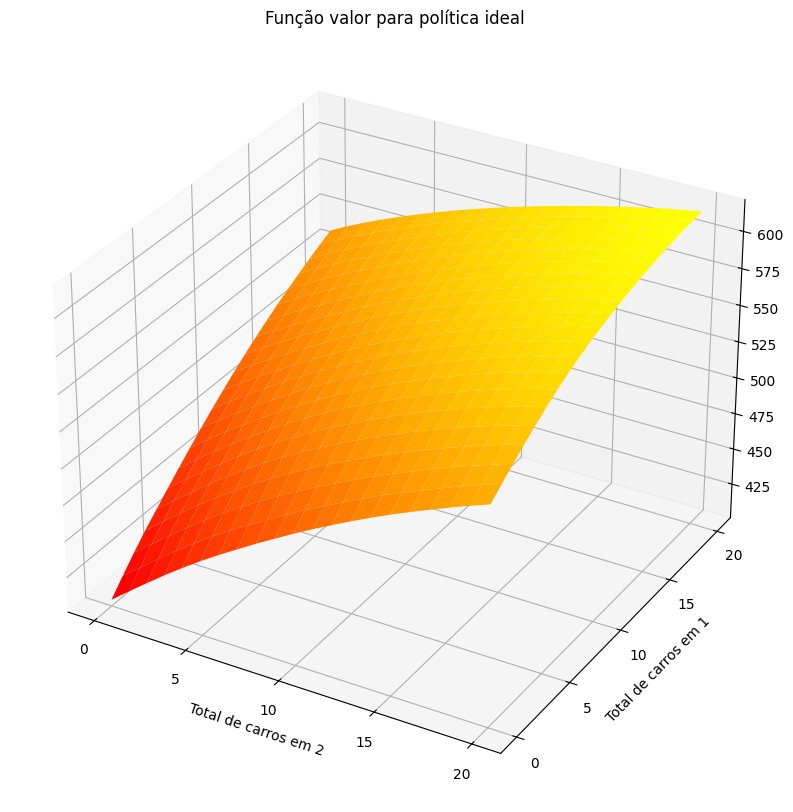

In [39]:
PlotValueFunction3D(v, maxCars)